In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Εισαγωγή εμπλουτισμένων δεδομένων ---
df_1d = pd.read_csv('../data/XAU_1d_with_indicators.csv', index_col='Date', parse_dates=True)
df_1h = pd.read_csv('../data/XAU_1h_with_indicators.csv', index_col='Date', parse_dates=True)

In [2]:
# --- 2. Στρατηγική Combo (RSI + MACD + ATR) ---
def generate_combo_signal(df):
    df['Signal_Combo'] = 0
    rsi_buy = df['RSI_14'] < 30
    macd_buy = df['MACD'] > df['MACD_Signal']
    atr_cond = df['ATR_14'] > df['ATR_14'].rolling(20).mean()
    df.loc[rsi_buy & macd_buy & atr_cond, 'Signal_Combo'] = 1
    df.loc[(df['RSI_14'] > 70) & (df['MACD'] < df['MACD_Signal']) & atr_cond, 'Signal_Combo'] = -1
    return df

In [3]:
# --- 3. Νέα πιο χαλαρή στρατηγική Combo2 (RSI + MACD μόνο) ---
def generate_combo2_signal(df):
    df['Signal_Combo2'] = 0
    rsi_buy = df['RSI_14'] < 30
    macd_buy = df['MACD'] > df['MACD_Signal']
    rsi_sell = df['RSI_14'] > 70
    macd_sell = df['MACD'] < df['MACD_Signal']
    df.loc[rsi_buy & macd_buy, 'Signal_Combo2'] = 1
    df.loc[rsi_sell & macd_sell, 'Signal_Combo2'] = -1
    return df

In [4]:
# --- 4. Νέα Στρατηγική Combo3 (EMA 50 vs EMA 100 crossover) ---
def generate_combo3_signal(df):
    df['Signal_Combo3'] = 0
    df.loc[df['EMA_50'] > df['EMA_100'], 'Signal_Combo3'] = 1
    df.loc[df['EMA_50'] < df['EMA_100'], 'Signal_Combo3'] = -1
    return df

In [5]:
# --- 5. Εφαρμογή σε 1D και 1H ---
for df in [df_1d, df_1h]:
    df = generate_combo_signal(df)
    df = generate_combo2_signal(df)
    df = generate_combo3_signal(df)

    df['Return'] = df['Close'].pct_change()
    df['Strategy_Return_Combo'] = df['Signal_Combo'].shift(1) * df['Return']
    df['Equity_Combo'] = (1 + df['Strategy_Return_Combo']).cumprod()

    df['Strategy_Return_Combo2'] = df['Signal_Combo2'].shift(1) * df['Return']
    df['Equity_Combo2'] = (1 + df['Strategy_Return_Combo2']).cumprod()

    df['Strategy_Return_Combo3'] = df['Signal_Combo3'].shift(1) * df['Return']
    df['Equity_Combo3'] = (1 + df['Strategy_Return_Combo3']).cumprod()

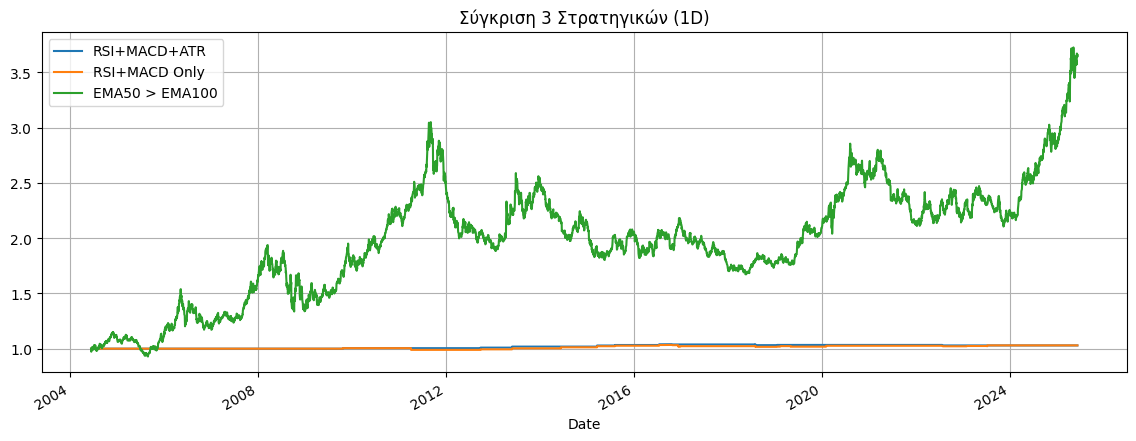

In [6]:
# --- 6. Οπτικοποίηση Σύγκρισης 3 Στρατηγικών (1D) ---
plt.figure(figsize=(14,5))
df_1d['Equity_Combo'].plot(label='RSI+MACD+ATR')
df_1d['Equity_Combo2'].plot(label='RSI+MACD Only')
df_1d['Equity_Combo3'].plot(label='EMA50 > EMA100')
plt.title('Σύγκριση 3 Στρατηγικών (1D)')
plt.grid(True)
plt.legend()
plt.show()



In [7]:
# --- 7. Στατιστικά Απόδοσης ---
print("\n===== Απόδοση Στρατηγικών 1D =====")
print("Final Equity RSI+MACD+ATR:", round(df_1d['Equity_Combo'].iloc[-1], 4))
print("Final Equity RSI+MACD:", round(df_1d['Equity_Combo2'].iloc[-1], 4))
print("Final Equity EMA50>EMA100:", round(df_1d['Equity_Combo3'].iloc[-1], 4))


===== Απόδοση Στρατηγικών 1D =====
Final Equity RSI+MACD+ATR: 1.0293
Final Equity RSI+MACD: 1.0298
Final Equity EMA50>EMA100: 3.6589


In [8]:
df_1d.to_csv('../data/XAU_1d_signals_combo_all.csv')
df_1h.to_csv('../data/XAU_1h_signals_combo_all.csv')